In [1]:
import pandas as pd

In [3]:
df= pd.read_csv("/content/sample_data/dengue data 17-07-2025.csv")
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,30-04-1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,07-05-1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,14-05-1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,21-05-1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,28-05-1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,28-05-2010,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,04-06-2010,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,11-06-2010,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,18-06-2010,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


🔧 Cell 1 — Install dependencies

In [1]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers peft accelerate==0.34.2 pandas scikit-learn matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.0 MB/s eta 0:00:00


📥 Cell 2 — Imports & device

In [2]:
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from transformers import GPT2Config, GPT2Model
from peft import LoraConfig, get_peft_model, TaskType

warnings.filterwarnings("ignore")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

📥 Cell 3 — Load & clean data (both cities together)

In [4]:
# Upload or point to your dataset
CSV_PATH = "/content/sample_data/dengue data 17-07-2025.csv"  # replace or upload
df = pd.read_csv(CSV_PATH)

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Parse dates
df['week_start_date'] = pd.to_datetime(df['week_start_date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['week_start_date'])

# Sort
df = df.sort_values(['city','week_start_date']).reset_index(drop=True)

# Features vs target
target_col = 'total_cases'
feature_cols = [c for c in df.columns if c not in ['city','week_start_date',target_col]]

# Fill missing values city-wise
def clean_city(g):
    g = g.copy()
    g[feature_cols] = g[feature_cols].ffill().bfill()
    g[target_col] = g[target_col].interpolate(limit_direction='both')
    return g.dropna()

df = df.groupby('city', group_keys=False).apply(clean_city).reset_index(drop=True)

print(df.city.value_counts())
df.head()


city
sj    936
iq    520
Name: count, dtype: int64


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


🧪 Cell 4 — Train/test split (per city, then merged)

In [5]:
# Time-based split: last 20% of each city reserved for test
def temporal_split(g, frac=0.2):
    n = len(g)
    n_test = int(max(1, round(n*frac)))
    return g.iloc[:-n_test], g.iloc[-n_test:]

train_parts, test_parts = [], []
for city, g in df.groupby('city'):
    tr, te = temporal_split(g, 0.2)
    train_parts.append(tr)
    test_parts.append(te)

train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)


Train shape: (1165, 25) Test shape: (291, 25)


🧱 Cell 5 — Dataset (patching + city embedding)

In [6]:
LOOKBACK = 24
HORIZON = 4
PATCH_LEN = 4
PATCH_STRIDE = 2
BATCH_SIZE = 64

# temporal encodings
def add_time_enc(g):
    g = g.copy()
    w = (g['weekofyear'] % 53).astype(float).values
    g['wofy_sin'] = np.sin(2*np.pi*w/53)
    g['wofy_cos'] = np.cos(2*np.pi*w/53)
    return g

# map city to integer
city2id = {c:i for i,c in enumerate(df['city'].unique())}

class TSForecastDS(Dataset):
    def __init__(self, df_city, scaler=None, fit_scaler=False):
        g = add_time_enc(df_city)
        self.features = [c for c in feature_cols if c not in ['year','weekofyear']] + ['wofy_sin','wofy_cos']
        X = g[self.features].values.astype(np.float32)
        y = g[target_col].values.astype(np.float32)
        city_ids = g['city'].map(city2id).values.astype(np.int64)

        if scaler is None:
            scaler = StandardScaler()
        if fit_scaler:
            X = scaler.fit_transform(X)
        else:
            X = scaler.transform(X)

        self.scaler = scaler
        self.g = g.reset_index(drop=True)
        self.X = X
        self.y = y
        self.city_ids = city_ids

        self.indices = []
        N = len(g)
        for t in range(LOOKBACK, N - HORIZON + 1):
            self.indices.append(t)

    def __len__(self):
        return len(self.indices)

    def _make_patches(self, hist):
        patches = []
        for start in range(0, LOOKBACK - PATCH_LEN + 1, PATCH_STRIDE):
            end = start + PATCH_LEN
            patch = hist[start:end].reshape(-1)
            patches.append(patch)
        return np.stack(patches, axis=0)

    def __getitem__(self, idx):
        t = self.indices[idx]
        hist_X = self.X[t-LOOKBACK:t]
        target = self.y[t:t+HORIZON]
        patches = self._make_patches(hist_X)
        city_id = self.city_ids[t]
        return {
            "tokens": torch.from_numpy(patches),
            "target": torch.from_numpy(target),
            "city_id": torch.tensor(city_id)
        }

def collate(batch):
    tokens = nn.utils.rnn.pad_sequence([b["tokens"] for b in batch], batch_first=True)
    target = torch.stack([b["target"] for b in batch])
    city_id = torch.stack([b["city_id"] for b in batch])
    return tokens, target, city_id


🧠 Cell 6 — Model (with city embedding)

In [7]:
class NumericPatchEmbed(nn.Module):
    def __init__(self, patch_dim, d_model):
        super().__init__()
        self.proj = nn.Linear(patch_dim, d_model)

    def forward(self, x):
        return self.proj(x)

class LLM4TSMultiCity(nn.Module):
    def __init__(self, patch_dim, num_cities, d_model=256, n_layer=6, n_head=8, horizon=HORIZON):
        super().__init__()
        self.embed = NumericPatchEmbed(patch_dim, d_model)
        self.city_emb = nn.Embedding(num_cities, d_model)

        cfg = GPT2Config(
            n_embd=d_model,
            n_layer=n_layer,
            n_head=n_head,
            n_positions=1024,
            n_ctx=1024,
            vocab_size=1
        )
        self.backbone = GPT2Model(cfg)
        lora_cfg = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            r=16, lora_alpha=16, lora_dropout=0.05,
            target_modules=["c_attn"]
        )
        self.backbone = get_peft_model(self.backbone, lora_cfg)

        self.reg_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Linear(d_model//2, horizon)
        )

    def forward(self, tokens, city_id):
        x = self.embed(tokens)  # [B,P,D]
        city_vec = self.city_emb(city_id)[:,None,:]  # [B,1,D]
        x = torch.cat([city_vec, x], dim=1)  # prepend city token
        out = self.backbone(inputs_embeds=x).last_hidden_state
        pooled = out[:, -1, :]
        pred = self.reg_head(pooled)
        return pred


🏋️ Cell 7 — Training & evaluation

In [9]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/np.clip(np.abs(y_true), eps, None)))*100

# --- FIX: add temporal encodings before scaling ---
train_df = add_time_enc(train_df)
test_df  = add_time_enc(test_df)

# Build datasets
scaler = StandardScaler().fit(
    train_df[[c for c in feature_cols if c not in ['year','weekofyear']] + ['wofy_sin','wofy_cos']]
)
train_ds = TSForecastDS(train_df, scaler, fit_scaler=False)
test_ds  = TSForecastDS(pd.concat([train_df, test_df], ignore_index=True), scaler, fit_scaler=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=collate)

# Model init
sample = train_ds[0]["tokens"]
P, Dpatch = sample.shape
model = LLM4TSMultiCity(patch_dim=Dpatch, num_cities=len(city2id)).to(DEVICE)

# Freeze backbone except LoRA
for n, p in model.backbone.named_parameters():
    if "lora_" not in n:
        p.requires_grad_(False)

opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
best_loss, best_state = float("inf"), None

# Training loop
for epoch in range(30):
    model.train()
    losses = []
    for tokens, target, city_id in train_loader:
        tokens, tgt, city_id = tokens.to(DEVICE).float(), target.to(DEVICE).float(), city_id.to(DEVICE)
        pred = model(tokens, city_id)
        loss = nn.functional.l1_loss(pred, tgt) + 0.2*nn.functional.mse_loss(pred, tgt)
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        losses.append(loss.item())
    eloss = np.mean(losses)
    print(f"Epoch {epoch+1}: loss={eloss:.4f}")
    if eloss < best_loss:
        best_loss, best_state = eloss, {k: v.cpu() for k, v in model.state_dict().items()}

if best_state:
    model.load_state_dict(best_state)


Epoch 1: loss=610.4257
Epoch 2: loss=605.4674
Epoch 3: loss=542.4133
Epoch 4: loss=489.6476
Epoch 5: loss=497.1451
Epoch 6: loss=473.1985
Epoch 7: loss=437.8547
Epoch 8: loss=380.1833
Epoch 9: loss=409.6805
Epoch 10: loss=388.5697
Epoch 11: loss=369.5102
Epoch 12: loss=360.8571
Epoch 13: loss=316.9453
Epoch 14: loss=314.8439
Epoch 15: loss=319.2382
Epoch 16: loss=271.7483
Epoch 17: loss=289.5845
Epoch 18: loss=287.9930
Epoch 19: loss=273.9271
Epoch 20: loss=274.5037
Epoch 21: loss=261.3148
Epoch 22: loss=249.0836
Epoch 23: loss=239.6001
Epoch 24: loss=218.8171
Epoch 25: loss=221.0597
Epoch 26: loss=207.6852
Epoch 27: loss=194.4282
Epoch 28: loss=169.4393
Epoch 29: loss=175.3370
Epoch 30: loss=154.8998


📊 Cell 8 — Forecasting & metrics (per city and overall)

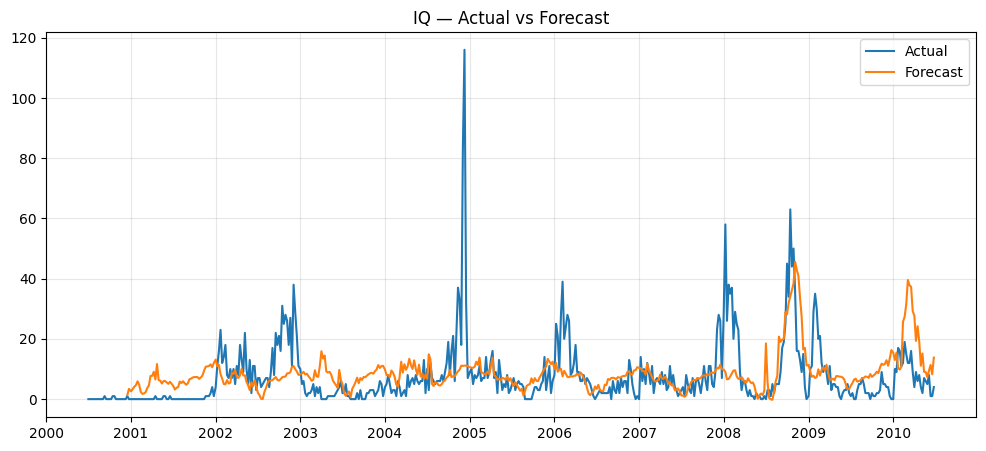

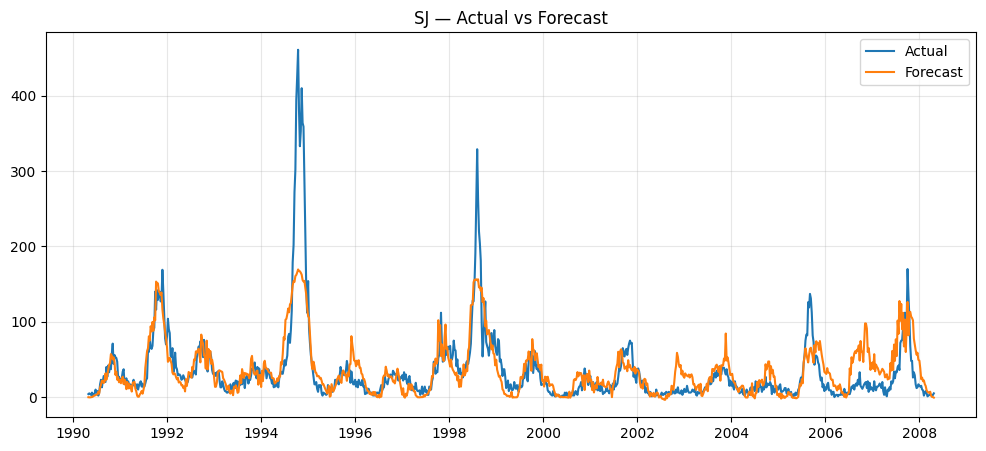

=== Metrics per city ===
iq {'RMSE': 11.185063102042816, 'MAE': 8.403166770935059, 'MAPE(%)': np.float64(86899015.54397592)}
sj {'RMSE': 30.786475405136812, 'MAE': 23.741090774536133, 'MAPE(%)': np.float64(8120793.790493904)}

=== Overall Metrics ===
{'RMSE': 25.569184639424854, 'MAE': 18.259496688842773, 'MAPE(%)': np.float64(36275209.81235689)}


In [10]:
# Get predictions
model.eval()
preds=[]
with torch.no_grad():
    for tokens, _, city_id in test_loader:
        tokens,city_id=tokens.to(DEVICE).float(), city_id.to(DEVICE)
        out=model(tokens,city_id).cpu().numpy()
        preds.append(out)
preds=np.concatenate(preds,axis=0)

# Align predictions with timeline
g_all=pd.concat([train_df,test_df],ignore_index=True).reset_index(drop=True)
start_idx=list(range(LOOKBACK,len(g_all)-HORIZON+1))
stitched=np.full(len(g_all),np.nan,dtype=np.float32)
for i,t in enumerate(start_idx):
    for h in range(HORIZON):
        stitched[t+h]=preds[i,h]

results={}
for city in df.city.unique():
    mask=(g_all['city']==city)&(g_all.index>=len(train_df))
    y_true=g_all.loc[mask,target_col].values
    y_pred=stitched[mask.index[mask]]
    valid=~np.isnan(y_pred)
    y_true,y_pred=y_true[valid],y_pred[valid]
    metrics={"RMSE":rmse(y_true,y_pred),
             "MAE":mean_absolute_error(y_true,y_pred),
             "MAPE(%)":mape(y_true,y_pred)}
    results[city]=metrics

    plt.figure(figsize=(12,5))
    plt.title(f"{city.upper()} — Actual vs Forecast")
    plt.plot(g_all.loc[g_all['city']==city,'week_start_date'],
             g_all.loc[g_all['city']==city,target_col],label="Actual")
    plt.plot(g_all.loc[g_all['city']==city,'week_start_date'],
             stitched[g_all['city']==city],label="Forecast")
    plt.legend(); plt.grid(True,alpha=0.3); plt.show()

print("=== Metrics per city ===")
for c,m in results.items(): print(c,m)

# Overall
mask=g_all.index>=len(train_df)
valid=~np.isnan(stitched[mask])
overall_true=g_all.loc[mask,target_col].values[valid]
overall_pred=stitched[mask][valid]
print("\n=== Overall Metrics ===")
print({"RMSE":rmse(overall_true,overall_pred),
       "MAE":mean_absolute_error(overall_true,overall_pred),
       "MAPE(%)":mape(overall_true,overall_pred)})


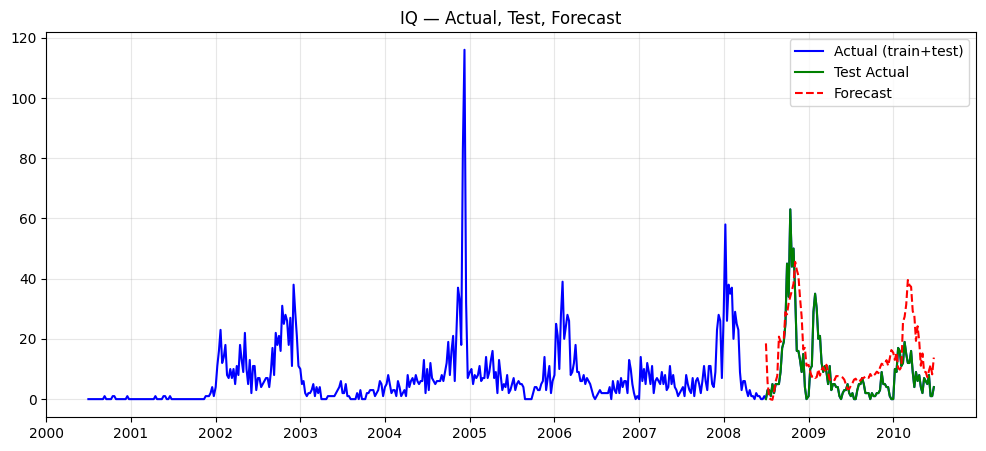

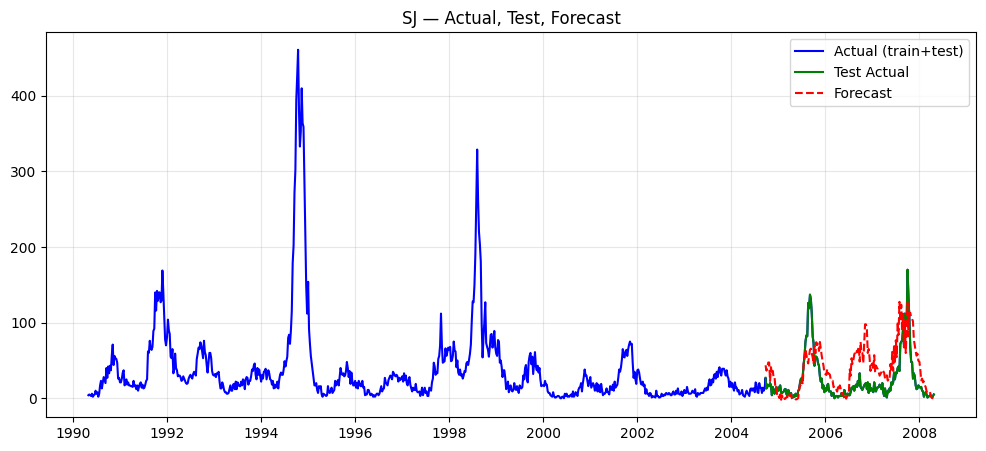

=== Metrics per city ===
iq {'RMSE': 11.185063102042816, 'MAE': 8.403166770935059, 'MAPE(%)': np.float64(86899015.54397592)}
sj {'RMSE': 30.786475405136812, 'MAE': 23.741090774536133, 'MAPE(%)': np.float64(8120793.790493904)}

=== Overall Metrics ===
{'RMSE': 25.569184639424854, 'MAE': 18.259496688842773, 'MAPE(%)': np.float64(36275209.81235689)}


In [11]:
# Get predictions
model.eval()
preds=[]
with torch.no_grad():
    for tokens, _, city_id in test_loader:
        tokens,city_id=tokens.to(DEVICE).float(), city_id.to(DEVICE)
        out=model(tokens,city_id).cpu().numpy()
        preds.append(out)
preds=np.concatenate(preds,axis=0)

# Align predictions with timeline
g_all=pd.concat([train_df,test_df],ignore_index=True).reset_index(drop=True)
start_idx=list(range(LOOKBACK,len(g_all)-HORIZON+1))
stitched=np.full(len(g_all),np.nan,dtype=np.float32)
for i,t in enumerate(start_idx):
    for h in range(HORIZON):
        stitched[t+h]=preds[i,h]

results={}
for city in df.city.unique():
    city_mask=(g_all['city']==city)
    mask_test=(city_mask) & (g_all.index>=len(train_df))

    # Split series
    y_full=g_all.loc[city_mask,target_col].values   # all actual
    y_true=g_all.loc[mask_test,target_col].values   # test actual
    y_pred=stitched[mask_test]                      # forecast
    valid=~np.isnan(y_pred)

    # Metrics
    metrics={"RMSE":rmse(y_true[valid],y_pred[valid]),
             "MAE":mean_absolute_error(y_true[valid],y_pred[valid]),
             "MAPE(%)":mape(y_true[valid],y_pred[valid])}
    results[city]=metrics

    # --- Plot ---
    plt.figure(figsize=(12,5))
    plt.title(f"{city.upper()} — Actual, Test, Forecast")
    # actual full history
    plt.plot(g_all.loc[city_mask,'week_start_date'],
             y_full,label="Actual (train+test)",color="blue")
    # highlight test actual
    plt.plot(g_all.loc[mask_test,'week_start_date'],
             y_true,label="Test Actual",color="green")
    # forecast
    plt.plot(g_all.loc[mask_test,'week_start_date'],
             y_pred,label="Forecast",color="red",linestyle="--")
    plt.legend(); plt.grid(True,alpha=0.3); plt.show()

print("=== Metrics per city ===")
for c,m in results.items(): print(c,m)

# Overall metrics
mask=g_all.index>=len(train_df)
valid=~np.isnan(stitched[mask])
overall_true=g_all.loc[mask,target_col].values[valid]
overall_pred=stitched[mask][valid]
print("\n=== Overall Metrics ===")
print({"RMSE":rmse(overall_true,overall_pred),
       "MAE":mean_absolute_error(overall_true,overall_pred),
       "MAPE(%)":mape(overall_true,overall_pred)})
